In [2]:
## Imports
import numpy as np
import torch
from PIL import Image
import os.path
import argparse
from pathlib import Path
import cv2
import heapq
from torch.nn import functional as F
from torch.utils.data import DataLoader
import tqdm
import einops
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from utils.factory import create_model_and_transforms, get_tokenizer
from utils.visualization import image_grid, visualization_preprocess
from prs_hook import hook_prs_logger
from matplotlib import pyplot as plt

In [3]:
## Hyperparameters

device = 'cuda:0'
pretrained = 'laion2b_s32b_b82k' # 'laion2b_s32b_b79k'
model_name = 'ViT-L-14' # 'ViT-H-14'
batch_size = 2 # only needed for the nn search
imagenet_path = '/datasets/ilsvrc_2024-01-04_1601/' # only needed for the nn search

In [4]:
## Loading Model

model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device)

/home/jennifer/clip_text_span/utils/factory.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)


Model parameters: 427,616,513
Context length: 77
Vocab size: 49408
Len of res: 24


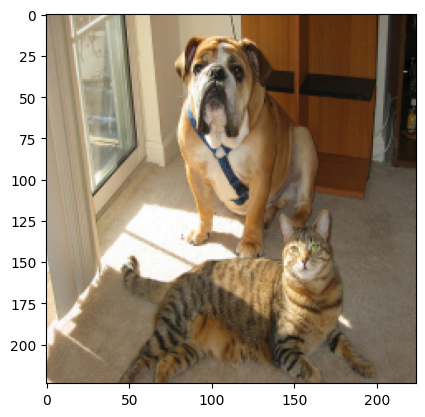

In [5]:
## Load image

image_pil = Image.open('images/catdog.png')
image = preprocess(image_pil)[np.newaxis, :, :, :]
_ = plt.imshow(image_pil)

In [6]:
## Run the image:
prs.reinit()
with torch.no_grad():
    representation = model.encode_image(image.to(device), 
                                        attn_method='head', 
                                        normalize=False)
    attentions, mlps = prs.finalize(representation)  # attentions: [1, 32, 257, 16, 1024], mlps: [1, 33, 1024]

## Visualize token decomposition

In [7]:
## Get the texts
lines = ['An image of a dog', 'An image of a cat']
texts = tokenizer(lines).to(device)  # tokenize
class_embeddings = model.encode_text(texts)
class_embedding = F.normalize(class_embeddings, dim=-1)

An image of a dog


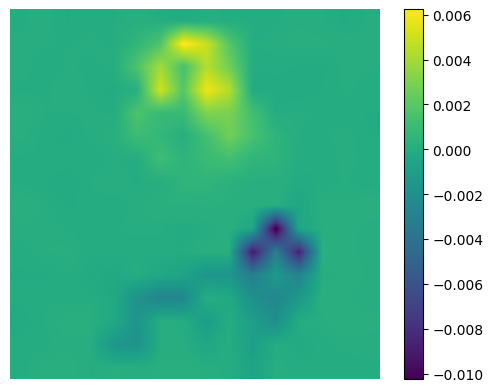

An image of a cat


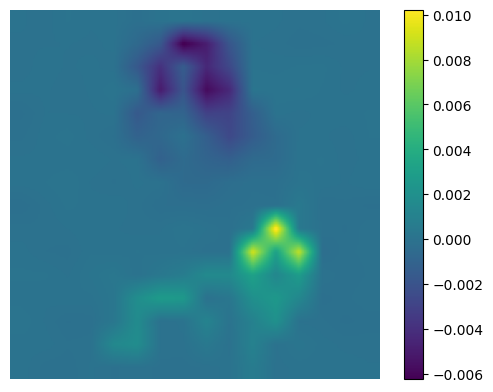

In [8]:
attention_map = attentions[0, :, 1:, :].sum(axis=(0,2)) @ class_embedding.T

# An image of a dog:
attention_map = F.interpolate(einops.rearrange(attention_map, '(B N M) C -> B C N M', N=16, M=16, B=1), 
                                  scale_factor=model.visual.patch_size[0],
                                  mode='bilinear').to(device)
attention_map = attention_map[0].detach().cpu().numpy()
print(lines[0])
plt.imshow(attention_map[0] - np.mean(attention_map,axis=0))

v = attention_map[0] - attention_map[1] # np.mean(attention_map,axis=0)
min_ = min((attention_map[0] - attention_map[1]).min(), (attention_map[1] - attention_map[0]).min())
max_ = max((attention_map[0] - attention_map[1]).max(), (attention_map[1] - attention_map[1]).max())
v = v - min_
v = np.uint8((v / (max_-min_))*255)
high = cv2.cvtColor(cv2.applyColorMap(v, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
plt.colorbar()
plt.axis('off')
plt.show()
print(lines[1])
plt.imshow(attention_map[1] - np.mean(attention_map,axis=0),)

v = attention_map[1] - attention_map[0]
v = v - min_
v = np.uint8((v / (max_-min_))*255)
high = cv2.cvtColor(cv2.applyColorMap(v, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
plt.colorbar()
plt.axis('off')
plt.show()